In [62]:
# test classification dataset
from sklearn.datasets import make_classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, recall_score
import RIfunctions as ri
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import GridSearchCV
import joblib
import seaborn as sns

In [63]:
data = pd.read_csv('RI_accept.csv', sep = ',', index_col=0)

In [64]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [65]:
data = data.loc[data['issue_d'] < '2016-1-1']

<AxesSubplot:>

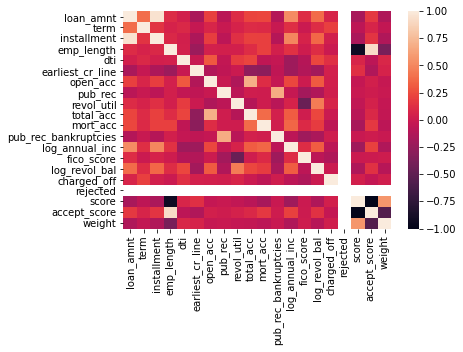

In [66]:
corr = data.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [67]:
all_cols = list(data.columns)
excl_cols = ['charged_off','weight','score','rejected','accept_score']
all_cols = [e for e in all_cols if e not in excl_cols]

In [68]:
to_drop_categorical = ['home_ownership', 'verification_status', 'purpose', 'application_type']
all_cols = [e for e in all_cols if e not in to_drop_categorical]
all_cols.remove('issue_d')

print('to scale     ', all_cols)

to scale      ['loan_amnt', 'term', 'installment', 'emp_length', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score', 'log_revol_bal']


In [69]:
data = pd.get_dummies(data,prefix=["hom","ver","purp","app"], columns=to_drop_categorical, drop_first=False)

In [70]:
train_df = data.loc[data['issue_d'] < data['issue_d'].quantile(0.80)]
test_df = data.loc[data['issue_d'] >= data['issue_d'].quantile(0.80)]

In [71]:
train_df.drop('issue_d', axis=1, inplace=True)
test_df.drop('issue_d', axis=1, inplace=True)

c:\Users\joshy\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [72]:
data.isna().sum()

loan_amnt                      0
term                           0
installment                    0
emp_length                 31490
issue_d                        0
dti                            0
earliest_cr_line               0
open_acc                       0
pub_rec                        0
revol_util                   368
total_acc                      0
mort_acc                   46857
pub_rec_bankruptcies         676
log_annual_inc                 0
fico_score                     0
log_revol_bal                  0
charged_off                    0
rejected                       0
score                          0
accept_score                   0
weight                         0
hom_MORTGAGE                   0
hom_OWN                        0
hom_RENT                       0
ver_Not Verified               0
ver_Source Verified            0
ver_Verified                   0
purp_car                       0
purp_credit_card               0
purp_debt_consolidation        0
purp_home_

In [73]:
# Similar to SimpleImputer 

# train_df['emp_length'].fillna(train_df['emp_length'].mean(), inplace = True)
# test_df['emp_length'].fillna(test_df['emp_length'].mean(), inplace=True)

train_df[all_cols] = train_df[all_cols].fillna(train_df[all_cols].mean())
test_df[all_cols] = test_df[all_cols].fillna(train_df[all_cols].mean())
print('null values      ', train_df.isnull().sum())
print(type(train_df))

null values       loan_amnt                  0
term                       0
installment                0
emp_length                 0
dti                        0
earliest_cr_line           0
open_acc                   0
pub_rec                    0
revol_util                 0
total_acc                  0
mort_acc                   0
pub_rec_bankruptcies       0
log_annual_inc             0
fico_score                 0
log_revol_bal              0
charged_off                0
rejected                   0
score                      0
accept_score               0
weight                     0
hom_MORTGAGE               0
hom_OWN                    0
hom_RENT                   0
ver_Not Verified           0
ver_Source Verified        0
ver_Verified               0
purp_car                   0
purp_credit_card           0
purp_debt_consolidation    0
purp_home_improvement      0
purp_house                 0
purp_major_purchase        0
purp_medical               0
purp_moving              

c:\Users\joshy\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [74]:
print(all_cols)

['loan_amnt', 'term', 'installment', 'emp_length', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score', 'log_revol_bal']


In [75]:
scaler = StandardScaler(copy=False)

train_df[all_cols] = scaler.fit_transform(train_df[all_cols], train_df['charged_off'])
test_df[all_cols] = scaler.transform(test_df[all_cols])

print(scaler.mean_)

<ipython-input-75-5b01b1f3d05f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[all_cols] = scaler.fit_transform(train_df[all_cols], train_df['charged_off'])
c:\Users\joshy\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-75-5b01b1f3d05f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

[1.40415078e+04 4.14630891e+01 4.30510182e+02 5.95569545e+00
 1.73229676e+01 1.99746141e+03 1.12369327e+01 1.73059035e-01
 5.54718511e+01 2.51595481e+01 1.80177734e+00 1.14148757e-01
 4.80064233e+00 6.97759913e+02 4.00680148e+00]


In [77]:
# # Downsampling. No logical strategy.

# print('train and test shape     ', train_df.shape, test_df.shape)

# train_df = ri.balanceData(train_df)
# test_df =  ri.balanceData(test_df)

# print('train and test shape     ', train_df.shape, test_df.shape)
# print('value counts train     ', train_df['charged_off'].value_counts())
# print('value counts test     ', test_df['charged_off'].value_counts())

In [78]:
# all_cols = list(data.columns)

# for i in all_cols:
#     if i.startswith("purp"):
#         numerical_cols.append(i)

# print(numerical_cols) 

# train_df_y = train_df['charged_off']
# train_df_x = train_df[numerical_cols]

# test_df_x = test_df[numerical_cols]
# test_df_y = test_df['charged_off']

In [79]:
train_df_y = train_df['charged_off']
train_df_x = train_df.drop(excl_cols, axis=1)
train_weights = train_df['weight']

test_df_x = test_df.drop(excl_cols, axis=1)
test_df_y = test_df['charged_off']
test_weights = test_df["weight"]

In [80]:
print(train_df_x.columns)

Index(['loan_amnt', 'term', 'installment', 'emp_length', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score',
       'log_revol_bal', 'hom_MORTGAGE', 'hom_OWN', 'hom_RENT',
       'ver_Not Verified', 'ver_Source Verified', 'ver_Verified', 'purp_car',
       'purp_credit_card', 'purp_debt_consolidation', 'purp_home_improvement',
       'purp_house', 'purp_major_purchase', 'purp_medical', 'purp_moving',
       'purp_other', 'purp_renewable_energy', 'purp_small_business',
       'purp_vacation', 'purp_wedding', 'app_Individual', 'app_Joint App'],
      dtype='object')


In [81]:
# ns = NearMiss(sampling_strategy='not minority')

# train_df_x, train_df_y  = ns.fit_resample(train_df_x, train_df_y)
# print(pd.DataFrame(train_df_y.value_counts()))

# test_df_x, test_df_y = ns.fit_resample(test_df_x, test_df_y)
# print(pd.DataFrame(test_df_y.value_counts()))

In [82]:
# # Synthesise binary classification dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
# # summarize the dataset
print(train_df_x.shape, train_df_y.shape)

(499893, 36) (499893,)


In [83]:
model = joblib.load("./random_forest.joblib")
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [84]:
model_2 = BalancedRandomForestClassifier(**model.get_params())
model_2.set_params(max_depth=12)
print(model_2.get_params())
model_2.fit(train_df_x, train_df_y, sample_weight=train_weights)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(criterion='entropy', max_depth=12,
                               max_features='log2', random_state=42)

In [85]:
# Hyperparameter tuning. Took over 11 hours to run.

# params_rf ={
#           'n_estimators': [100,300,400,500, 600,1000],
#           'criterion': ["gini", "entropy"],
#           'max_depth': [100,200, 300, 400, 1000],
#           'max_features': ["log2", "sqrt"],
#           'bootstrap':[True, False]
# }

# grid_rf = GridSearchCV(estimator=model, param_grid=params_rf ,cv = 3, scoring="neg_mean_squared_error", verbose = 1, n_jobs=-1)
# grid_rf.fit(train_df_x, train_df_y)

# best_hyperparams = grid_rf.best_params_
# print("Best hyperparameters: \n", best_hyperparams )
# best_rf = grid_rf.best_estimator_

In [86]:
# Saving the model

# joblib.dump(best_rf, "./random_forest.joblib")

In [87]:
# 10 fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# cv_scores_train = cross_val_score(estimator= model, X=train_df_x, y=train_df_y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print("(Training Set) The cross-validation accuracy score for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train), std(cv_scores_train)))

# cv_scores_test = cross_val_score(estimator= model, X=test_df_x, y=test_df_y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print("(Test Set) The cross-validation accuracy score for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test), std(cv_scores_test)))

In [88]:
# 10 fold cross roc_auc
cv_scores_train = cross_val_score(estimator= model_2, X=train_df_x, y=train_df_y, scoring='roc_auc', cv=10, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train), std(cv_scores_train)))

cv_scores_test = cross_val_score(estimator= model_2, X=test_df_x, y=test_df_y, scoring='roc_auc', cv=10, n_jobs=-1)
print("(Test Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test), std(cv_scores_test)))

(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.701 (0.014)
(Test Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.706 (0.006)


In [89]:
yhat = model.predict(test_df_x)
print(roc_auc_score(test_df_y, yhat), recall_score(test_df_y, yhat, pos_label=1), recall_score(test_df_y, yhat, pos_label=0))

c:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- app_Individual
- app_Joint App
- earliest_cr_line
- fico_score
- hom_MORTGAGE
- ...
Feature names seen at fit time, yet now missing:
- purp_educational

  warnings.warn(message, FutureWarning)


ValueError: X has 36 features, but RandomForestClassifier is expecting 17 features as input.